<h1 style="text-align:center">Deep Learning  Lab Session </h1>
<h1 style="text-align:center">First Lab Session - 3 Hours </h1>
<h1 style="text-align:center">Artificial Neural Networks for Handwritten Digits Recognition</h1>

<b> Student 1:</b> Luca Lombardo 
<b> Student 2:</b> Claudio Scalzo 
<b> Group name:</b> deeplearn8
 
 
The aim of this session is to practice with Artificial Neural Networks. Answers and experiments should be made by groups of two students. Each group should fill and run appropriate notebook cells. 

To generate your final report and upload it on the submission website http://bigfoot-m1.eurecom.fr/teachingsub/login (using your deeplearnXX/password). Do not forget to run all your cells before generating your final report and do not forget to include the names of all participants in the group. The lab session should be completed ans submitted by April 13th 2018 (23:59:59 CET). 

In [3]:
import time
import random
import numpy as np
from utils import *
from transfer_functions import * 


class NeuralNetwork(object):
    
    def __init__(self, input_layer_size, hidden_layer_size, output_layer_size, transfer_f=sigmoid, transfer_df=dsigmoid):
        """
        input_layer_size: number of input neurons
        hidden_layer_size: number of hidden neurons
        output_layer_size: number of output neurons
        iterations: number of iterations
        learning_rate: initial learning rate
        """

        # initialize transfer functions
        self.transfer_f = transfer_f
        self.transfer_df = transfer_df

        # initialize layer sizes
        self.input_layer_size = input_layer_size+1  # +1 for the bias node in the input Layer
        self.hidden_layer_size = hidden_layer_size+1 # +1 for the bias node in the hidden layer 
        self.output_layer_size = output_layer_size

        # initialize arrays for activations
        self.u_hidden = np.zeros((1, self.hidden_layer_size-1))
        self.u_output = np.zeros((1, self.output_layer_size))

        # initialize arrays for outputs
        self.o_input = np.ones((1, self.input_layer_size))
        self.o_hidden = np.ones((1, self.hidden_layer_size))
        self.o_output = np.ones((1, self.output_layer_size))

        # initialize arrays for partial derivatives according to activations
        self.dE_du_hidden = np.zeros((1, self.hidden_layer_size-1))
        self.dE_du_output = np.zeros((1, self.output_layer_size))

        # create randomized weights Yann LeCun method in 1988's paper ( Default values)
        input_range = 1.0 / self.input_layer_size ** (1/2)
        self.W_input_to_hidden = np.random.normal(loc = 0, scale = input_range, size =(self.input_layer_size, self.hidden_layer_size-1))
        self.W_hidden_to_output = np.random.uniform(size = (self.hidden_layer_size, self.output_layer_size)) / np.sqrt(self.hidden_layer_size)

    def weights_init(self,wi=None,wo=None):
        input_range = 1.0 / self.input_layer_size ** (1/2)
        if wi is not None:
            self.W_input_to_hidden = wi # weights between input and hidden layers
        else:
            self.W_input_to_hidden = np.random.normal(loc = 0, scale = input_range, size =(self.input_layer_size, self.hidden_layer_size-1))
        if wo is not None:
            self.W_hidden_to_output = wo # weights between hidden and output layers
        else:
            self.W_hidden_to_output = np.random.uniform(size = (self.hidden_layer_size, self.output_layer_size)) / np.sqrt(self.hidden_layer_size)

    
    def train(self, data, validation_data, iterations=50, learning_rate=5.0, verbose=False):
        start_time = time.time()
        training_accuracies = []
        validation_accuracies = []
        inputs  = data[0]
        targets = data[1]
        best_val_acc = 100*self.predict(validation_data)/len(validation_data[0])
        best_i2h_W = self.W_input_to_hidden
        best_h2o_W = self.W_hidden_to_output
        batch_size = min(128, len(inputs))
        for it in range(iterations):
            inputs_mb, targets_mb = zip(*random.sample(list(zip(inputs, targets)), batch_size)) 
            self.feedforward(inputs_mb)
            self.backpropagate(targets_mb, learning_rate=learning_rate)
            error = np.array(targets_mb) - self.o_output
            error *= error
            training_accuracies.append(100*self.predict(data)/len(data[0]))
            validation_accuracies.append(100*self.predict(validation_data)/len(validation_data[0]))
            if validation_accuracies[-1] > best_val_acc:
                best_i2h_W = self.W_input_to_hidden
                best_h2o_W = self.W_hidden_to_output
            if verbose:
                print("[Iteration %2d/%2d]  -Training_Accuracy:  %2.2f %%  -Validation_Accuracy: %2.2f %%  -time: %2.2f " %(it+1, iterations,
                                                                training_accuracies[-1], validation_accuracies[-1], time.time() - start_time))
                print("    - MSE:", np.sum(error)/len(targets_mb))
        print("Training time:", time.time()-start_time)
        plot_train_val(range(1, iterations+1), training_accuracies, validation_accuracies, "Accuracy")
       
    def train_xe(self, data, validation_data, iterations=50, learning_rate=5.0, verbose=False):
        start_time = time.time()
        training_accuracies = []
        validation_accuracies = []
        xes = []
        inputs  = data[0]
        targets = data[1]
        best_val_acc = 100*self.predict(validation_data)/len(validation_data[0])
        best_i2h_W = self.W_input_to_hidden
        best_h2o_W = self.W_hidden_to_output
        batch_size = min(128, len(inputs))
        for it in range(iterations):
            inputs_mb, targets_mb = zip(*random.sample(list(zip(inputs, targets)), batch_size))
            self.feedforward_xe(inputs_mb)
            self.backpropagate_xe(targets_mb, learning_rate=learning_rate)
            xe = np.array(targets_mb)*np.log(self.o_output)*(-1)
            error = np.array(targets_mb) - self.o_output
            error *= error
            training_accuracies.append(100*self.predict(data)/len(data[0]))
            validation_accuracies.append(100*self.predict(validation_data)/len(validation_data[0]))
            if validation_accuracies[-1] > best_val_acc:
                best_i2h_W = self.W_input_to_hidden
                best_h2o_W = self.W_hidden_to_output
            if verbose:
                print("[Iteration %2d/%2d]  -Training_Accuracy:  %2.2f %%  -Validation_Accuracy: %2.2f %%  -time: %2.2f " %(it+1, iterations,
                                                            training_accuracies[-1], validation_accuracies[-1], time.time() - start_time))
                print("    - MSE:", np.sum(error)/len(targets_mb))
                print("    - X-Entropy:", np.sum(xe)/len(targets_mb))
        print("Training time:", time.time()-start_time)
        self.W_input_to_hidden = best_i2h_W
        self.W_hidden_to_output = best_h2o_W
        plot_train_val(range(1, iterations+1), training_accuracies, validation_accuracies, "Accuracy")

    def predict(self, test_data):
        """ Evaluate performance by counting how many examples in test_data are correctly 
            evaluated. """
        self.feedforward(test_data[0])
        answer = np.argmax(test_data[1], axis=1)
        prediction = np.argmax(self.o_output, axis=1)
        count = len(test_data[0]) - np.count_nonzero(answer - prediction)
        return count 

# Introduction

During this lab session, you will implement, train and test a Neural Network
for the Handwritten Digits Recognition problem <a href="http://yann.lecun.com/exdb/mnist/"> [1] </a> with  different settings of hyperparameters. You will use the MNIST dataset which was constructed from scanned documents available from the National Institute of Standards and Technology (NIST). Images of digits were taken from a variety of scanned documents, normalized in size and centered. 


<img src="Nimages/mnist.png",width="350" height="500" align="center">
<center><span>Figure 1: MNIST digits examples</span></center>


This assignment includes a written part of programms to help you understand how to build and train
your neural net and then to test your code and get results. 

1. <a href="NeuralNetwork.py"> NeuralNetwork.py </a> 
2. <a href="transfer_functions.py"> transfer_functions.py </a> 
3.  <a href="utils.py "> utils.py </a> 


Functions defined inside the python files mentionned above can be imported  using the python command "from filename import function".

You will use the following libraries:

1. <a href="http://cs231n.github.io/python-numpy-tutorial/"> numpy </a>: for creating arrays and using methods to manipulate arrays;

2. <a href="http://matplotlib.org/"> matplotlib  </a>: for making plots.

Before starting the lab, please launch the cell below. After that, you may not need to do any imports during the lab.

In [2]:
# All imports
from NeuralNetwork import NeuralNetwork
from transfer_functions import *
from utils import *
import numpy as np
import matplotlib

# Section 1 :  Your First Neural Network

<b>Part 1</b>: Before designing and writing your code, you will first work on a neural network by hand. 
Consider the following neural network with two inputs $x=(x_1,x_2)$, one hidden layer and a single output unit $y$.
The initial weights are set to random values. Neurons 6 and 7 represent biases. Bias values are equal to 1. You will consider a training sample whose feature vector is $x = (0.8, 0.2)$ and whose label is $y = 0.4$.

Assume that neurons have a sigmoid activation function  $f(x)=\frac{1}{(1+e^{-x})}$. The loss function $L$ is a Mean Squared Error (MSE): if $o$ denotes the output of the neural network, then the loss for a given sample $(o, y)$ is $L(o, y) = \left|\left| o - y \right|\right|^2$. In the following, you will assume that if you want to backpropagate the error on a whole batch, you will backpropagate the average error on that batch. More formally, let $((x^{(1)}, y^{(1)}), ..., (x^{(N)}, y^{(N)}))$ be a batch and $o^{(k)}$ the output associated to $x^{(k)}$. Then the total error $\bar{L}$ will be as follows:

<div align="center">$\bar{L} = \frac{1}{N} \sum_{k=1}^{N} L(o^{(k)}, y^{(k)})$.</div>




<img src="Nimages/NN.png", width="700" height="900"> 
<center><span>Figure 2: Neural network </span></center>


<b>Question 1.1.1</b>: Compute the new values of weights $w_{i,j}$ after a forward pass and a backward pass, and the outputs of the neural network before and after the backward path, when the learning rate is $\lambda$=5.
$w_{i,j}$ is the weight of the connexion between neuron $i$ and neuron $j$. Please detail your computations in the cell below and print your answers.

In [7]:
# START VARIABLES
lr = 5.0
x1, x2, x6, x7 = 0.8, 0.2, 1.0, 1.0
w13, w14, w23, w24, w63, w64 = 0.3, -0.5, 0.8, 0.2, 0.2, -0.4
w35, w45, w75 = -0.6, 0.4, 0.5
y = 0.4

In [116]:
x3 = sigmoid(np.array([w13, w23, w63]).dot(np.array([x1, x2, x6])))
x4 = sigmoid(np.array([w14, w24, w64]).dot(np.array([x1, x2, x6])))
x5 = sigmoid(np.array([w35, w45, w75]).dot(np.array([x3, x4, x7])))

print("=== FORWARD PASS 1 ===")
print("Output =", x5)

# VARIATIONS OF ERROR WRT WEIGHTS (hidden -> output)
d_w35 = 2 * (x5 - y) * x5 * (1 - x5) * x3
d_w45 = 2 * (x5 - y) * x5 * (1 - x5) * x4
d_w75 = 2 * (x5 - y) * x5 * (1 - x5) * x7

# VARIATIONS OF ERROR WRT WEIGHTS (input -> hidden)
d_w13 = x1 * (1 - x3) * d_w35 * w35
d_w14 = x1 * (1 - x4) * d_w45 * w45
d_w23 = x2 * (1 - x3) * d_w35 * w35
d_w24 = x2 * (1 - x4) * d_w45 * w45
d_w63 = x6 * (1 - x3) * d_w35 * w35
d_w64 = x6 * (1 - x4) * d_w45 * w45

# WEIGHTS UPDATE
w13 -= lr*d_w13
w14 -= lr*d_w14
w23 -= lr*d_w23
w24 -= lr*d_w24
w63 -= lr*d_w63
w64 -= lr*d_w64
w35 -= lr*d_w35
w45 -= lr*d_w45
w75 -= lr*d_w75

print("=== BACKWARD PASS ===")
print("w13 =", w13)
print("w14 =", w14)
print("w23 =", w23)
print("w24 =", w24)
print("w63 =", w63)
print("w64 =", w64)
print("w35 =", w35)
print("w45 =", w45)
print("w75 =", w75)

# OUTPUT CALCULATION
x3 = sigmoid(np.array([w13, w23, w63]).dot(np.array([x1, x2, x6])))
x4 = sigmoid(np.array([w14, w24, w64]).dot(np.array([x1, x2, x6])))
x5 = sigmoid(np.array([w35, w45, w75]).dot(np.array([x3, x4, x7])))

print("=== FORWARD PASS 2 ===")
print("Output =", x5)

=== FORWARD PASS 1 ===
Output = 0.5597295991095776
=== BACKWARD PASS ===
w13 = 0.3432265432215471
w14 = -0.5273473101875394
w23 = 0.8108066358053868
w24 = 0.19316317245311515
w63 = 0.2540331790269339
w64 = -0.4341841377344243
w35 = -0.8541467506279605
w45 = 0.2745727217772572
w75 = 0.10637455535192797
=== FORWARD PASS 2 ===
Output = 0.40648823589210115


<b>Part 2</b>: Neural Network Implementation

Please read all source files carefully and understand the data structures and all functions.
You are to complete the missing code. 
First you should define the neural network (using the NeuralNetwork class, see in the <a href="NeuralNetwork.py"> NeuralNetwork.py</a> file) and reinitialise weights. 
Then you will need to complete the feedforward() and the backpropagate() functions. 

<b>Question 1.2.1</b>: Implement the feedforward() function.

In [4]:
class NeuralNetwork(NeuralNetwork):
    def feedforward(self, inputs):
        self.o_input = np.array(inputs)
        
        # ADD COLUMN OF '1' TO INPUTS - IT'S THE BIAS
        if len(inputs[0]) == self.input_layer_size - 1:
            self.o_input = np.append(self.o_input, np.ones((len(inputs), 1)), axis=1)
        
        # FEEDFORWARD INPUT TO HIDDEN
        self.u_hidden = self.o_input.dot(self.W_input_to_hidden)
        self.o_hidden = self.transfer_f(self.u_hidden)
        
        # ADD COLUMN OF '1' TO O_HIDDEN - IT'S THE BIAS
        self.o_hidden = np.append(self.o_hidden, np.ones((len(self.o_hidden), 1)), axis=1)
        
        # FEEDFORWARD HIDDEN TO OUTPUT
        self.u_output = self.o_hidden.dot(self.W_hidden_to_output)
        self.o_output = self.transfer_f(self.u_output)

<b>Question 1.2.2</b>: Test your implementation: create the Neural Network defined in Part 1 and see if the feedforward() function you implemented gives the same results as the ones you found by hand.

In [10]:
# First define your neural network
model = NeuralNetwork(2, 2, 1, sigmoid, dsigmoid)

# Then initialize the weights according to Figure 2
# before running this box remember to re-initialize variables (updated by backward by hand)!
W_input_to_hidden = np.array([[w13, w14], [w23, w24], [w63, w64]])
W_hidden_to_output = np.array([[w35], [w45], [w75]])
model.weights_init(W_input_to_hidden, W_hidden_to_output)

# Feed test values
test = [[0.8, 0.2]]
model.feedforward(test)

# Print the output
print("Output =", model.o_output[0,0])

Output = 0.5597295991095776


<b>Question 1.2.3</b>: Implement the backpropagate() function.

In [5]:
class NeuralNetwork(NeuralNetwork):
    def backpropagate(self, targets, learning_rate=5.0):
        # COMPUTE dE/dU FOR OUTPUT LAYER
        dE_dU_output = np.multiply(self.o_output - targets, self.transfer_df(self.u_output))
        
        # COMPUTE dE/dW FOR HIDDEN LAYER
        dE_dU_hidden = np.multiply(dE_dU_output.dot(self.W_hidden_to_output.T), self.o_hidden * (1 - self.o_hidden))
        dE_dU_hidden = np.delete(dE_dU_hidden, -1, axis=1)
    
        # COMPUTE dE/dW MATRIX NORMALIZING
        dE_dW_hidden = (2/len(targets)) * dE_dU_hidden.T.dot(self.o_input).T
        dE_dW_output = (2/len(targets)) * dE_dU_output.T.dot(self.o_hidden).T
        
        # UPDATE WEIGHTS
        self.W_hidden_to_output -= learning_rate * dE_dW_output
        self.W_input_to_hidden -= learning_rate * dE_dW_hidden

<b>Question 1.2.4</b>: Test your implementation: create the Neural Network defined in Part 1 and see if the backpropagate() function you implemented gives the same weight updates as the ones you found by hand. Do another forward pass and see if the new output is the same as the one you obtained in Question 1.1.1.

In [28]:
# First define your neural network
model = NeuralNetwork(2, 2, 1, sigmoid, dsigmoid)

# Then initialize the weights according to Figure 2
W_input_to_hidden = np.array([[w13, w14], [w23, w24], [w63, w64]])
W_hidden_to_output = np.array([[w35], [w45], [w75]])
model.weights_init(W_input_to_hidden, W_hidden_to_output)

# Feed test values
test = [[0.8, 0.2]]
model.feedforward(test)

# Backpropagate
targets = [[0.4]]
model.backpropagate(targets)

# Print weights
print("W_input_to_hidden =", model.W_input_to_hidden)
print("W_hidden_to_output =", model.W_hidden_to_output)

# Feed test values again
model.feedforward(test)

# Print the output
print("Output =", model.o_output[0,0])

W_input_to_hidden = [[ 0.34322654 -0.52734731]
 [ 0.81080664  0.19316317]
 [ 0.25403318 -0.43418414]]
W_hidden_to_output = [[-0.85414675]
 [ 0.27457272]
 [ 0.10637456]]
Output = 0.40648823589210104


Checked your implementations and found that everything was fine? Congratulations! You can move to the next section.

# Section 2: Handwritten Digits Recognition

The MNIST dataset consists of handwritten digit images. It is split into a training set containing 60,000 samples and a test set containing 10,000 samples. In this Lab Session, the official training set of 60,000 images is divided into an actual training set of 50,000 samples a validation set of 10,000 samples. All digit images have been size-normalized and centered in a fixed size image of 28 x 28 pixels. Images are stored in byte form: you will use the NumPy python library to convert data files into NumPy arrays that you will use to train your Neural Networks.

You will first work with a small subset of MNIST (1000 samples), then on a very small subset of MNIST (10 samples), and eventually run a model on the whole one.

The MNIST dataset is available in the Data folder.
To get the training, testing and validation data, run the load_data() function.


In [6]:
# Just run that cell ;-)
training_data, validation_data, test_data = load_data()
small_training_data = (training_data[0][:1000], training_data[1][:1000])
small_validation_data = (validation_data[0][:200], validation_data[1][:200])
indices = [1, 3, 5, 7, 2, 0, 13, 15, 17, 4]
vsmall_training_data = ([training_data[0][i] for i in indices], [training_data[1][i] for i in indices])

Loading MNIST data .....
Done.


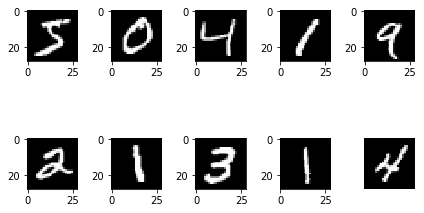

In [33]:
# And you can run that cell if you want to see what the MNIST dataset looks like
ROW = 2
COLUMN = 5
for i in range(ROW * COLUMN):
    # train[i][0] is i-th image data with size 28x28
    image = np.array(training_data[0][i]).reshape(28, 28)   
    plt.subplot(ROW, COLUMN, i+1)          
    plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
plt.axis('off')  # do not show axis value
plt.tight_layout()   # automatic padding between subplots
plt.show()

<b>Part 1</b>: Build a bigger Neural Network

The input layer of the neural network that you will build contains neurons encoding the values of the input pixels. The training data for the network will consist of many 28 by 28 pixel images of scanned handwritten digits. Thus, the input layer contains 784=28×28 units. The second layer of the network is a hidden layer. We set the number of neurons in the hidden layer to 30. The output layer contains 10 neurons.

<b>Question 2.1.1</b>: Create the network described above using the NeuralNetwork class.

In [46]:
# Define your neural network
mnist_model = NeuralNetwork(784, 30, 10, sigmoid, dsigmoid)

<b>Question 2.1.2</b>: Train your Neural Network on the small subset of MNIST (300 iterations) and print the new accuracy on test data. You will use small_validation_data for validation. Try different learning rates (0.1, 1.0, 10.0). You should use the train() function of the NeuralNetwork class to train your network, and the weights_init() function to reinitialize weights between tests. Print the accuracy of each model on test data using the predict() function.

Training time: 9.88961386680603


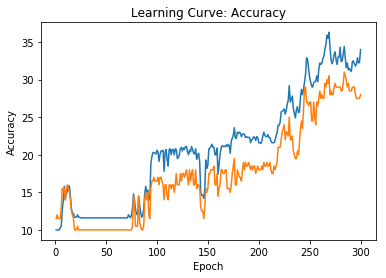

In [41]:
# Train NN and print accuracy on test data
# Learning rate 0.1
# Learning rate 1.
# Learning rate 10.
mnist_model.train(small_training_data, small_validation_data, iterations=300, learning_rate=0.1, verbose=False)

Training time: 9.955782651901245


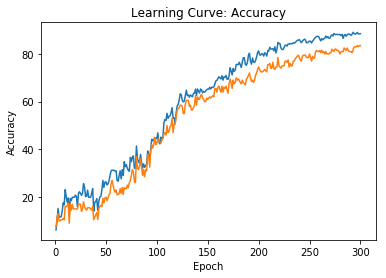

In [13]:
mnist_model.train(small_training_data, small_validation_data, iterations=300, learning_rate=1., verbose=False)

Training time: 9.74865436553955


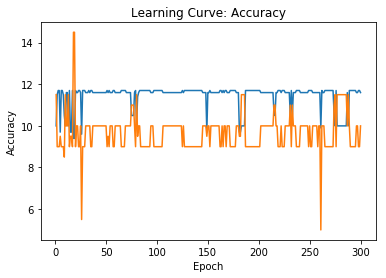

In [19]:
mnist_model.train(small_training_data, small_validation_data, iterations=300, learning_rate=10, verbose=False)

Training time: 9.578993797302246


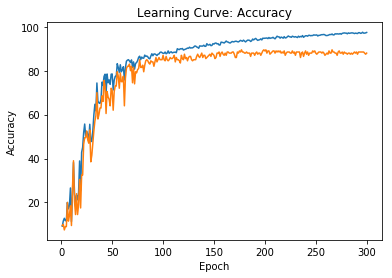

In [47]:
mnist_model.train(small_training_data, small_validation_data, iterations=300, learning_rate=2.0, verbose=False)

<b>Question 2.1.3</b>: Do the same with 15 and 75 hidden neurons.

15 HIDDEN LAYERS - LEARNING RATE 0.1
Training time: 9.371032238006592


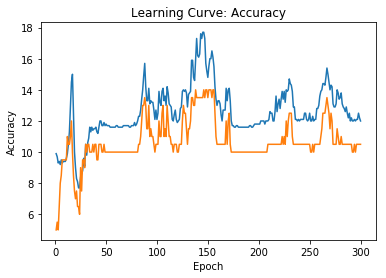

---------------------------------------------------
15 HIDDEN LAYERS - LEARNING RATE 1.0
Training time: 8.995779752731323


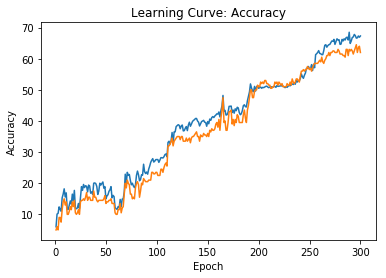

---------------------------------------------------
15 HIDDEN LAYERS - LEARNING RATE 10.0
Training time: 8.965885400772095


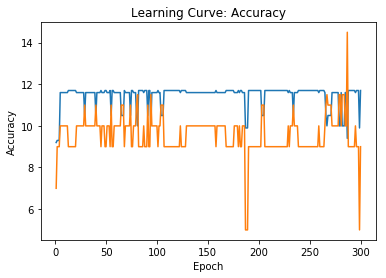

---------------------------------------------------
15 HIDDEN LAYERS - LEARNING RATE 2.0
Training time: 8.955021381378174


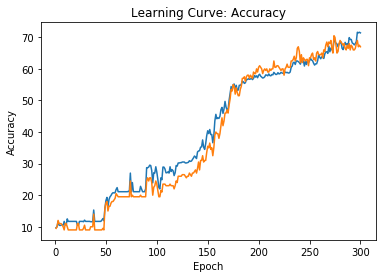

---------------------------------------------------
---------------------------------------------------
75 HIDDEN LAYERS - LEARNING RATE 0.1
Training time: 10.561725616455078


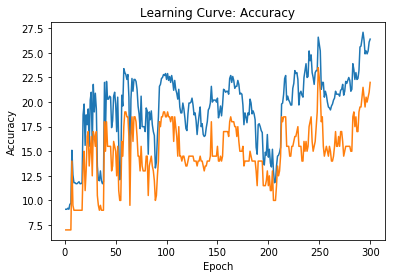

---------------------------------------------------
75 HIDDEN LAYERS - LEARNING RATE 1.0
Training time: 10.538610219955444


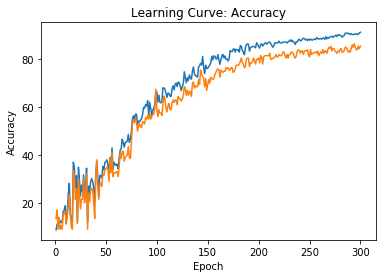

---------------------------------------------------
75 HIDDEN LAYERS - LEARNING RATE 10.0
Training time: 10.545135736465454


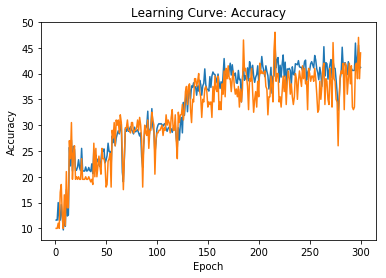

---------------------------------------------------
75 HIDDEN LAYERS - LEARNING RATE 2.0
Training time: 10.543506383895874


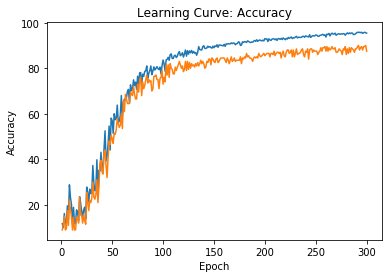

In [20]:
# Define your neural network
# 15 hidden neurons 
# Learning rate 0.1
# Learning rate 1.
# Learning rate 10.
mnist_model = NeuralNetwork(784, 15, 10, sigmoid, dsigmoid)
print("15 HIDDEN LAYERS - LEARNING RATE 0.1")
mnist_model.train(small_training_data, small_validation_data, iterations=300, learning_rate=0.1, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("15 HIDDEN LAYERS - LEARNING RATE 1.0")
mnist_model.train(small_training_data, small_validation_data, iterations=300, learning_rate=1, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("15 HIDDEN LAYERS - LEARNING RATE 10.0")
mnist_model.train(small_training_data, small_validation_data, iterations=300, learning_rate=10, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("15 HIDDEN LAYERS - LEARNING RATE 2.0")
mnist_model.train(small_training_data, small_validation_data, iterations=300, learning_rate=2, verbose=False)

# 75 hidden neurons
# Learning rate 0.1
# Learning rate 1.
# Learning rate 10.
mnist_model = NeuralNetwork(784, 75, 10, sigmoid, dsigmoid)
print("---------------------------------------------------")
print("---------------------------------------------------")
print("75 HIDDEN LAYERS - LEARNING RATE 0.1")
mnist_model.train(small_training_data, small_validation_data, iterations=300, learning_rate=0.1, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("75 HIDDEN LAYERS - LEARNING RATE 1.0")
mnist_model.train(small_training_data, small_validation_data, iterations=300, learning_rate=1, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("75 HIDDEN LAYERS - LEARNING RATE 10.0")
mnist_model.train(small_training_data, small_validation_data, iterations=300, learning_rate=10, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("75 HIDDEN LAYERS - LEARNING RATE 2.0")
mnist_model.train(small_training_data, small_validation_data, iterations=300, learning_rate=2, verbose=False)

<b>Question 2.1.3</b>: Repeat Questions 2.1.2 and 2.1.3 on the very small datasets. You will use small_validation_data for validation.

30 HIDDEN LAYERS - LEARNING RATE 0.1
Training time: 1.8438043594360352


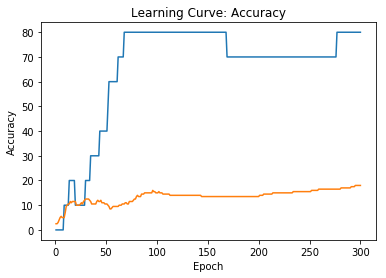

---------------------------------------------------
30 HIDDEN LAYERS - LEARNING RATE 1.0
Training time: 1.4466934204101562


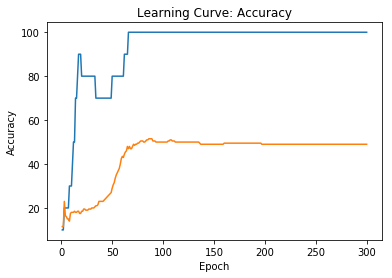

---------------------------------------------------
30 HIDDEN LAYERS - LEARNING RATE 10.0
Training time: 1.7014482021331787


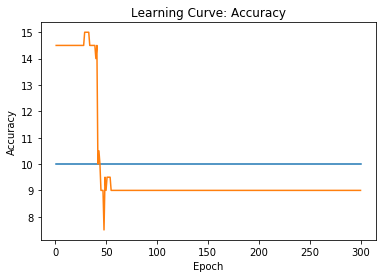

---------------------------------------------------
30 HIDDEN LAYERS - LEARNING RATE 2.0
Training time: 1.4475071430206299


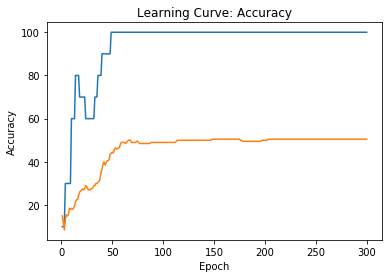

---------------------------------------------------
---------------------------------------------------
15 HIDDEN LAYERS - LEARNING RATE 0.1
Training time: 1.378507137298584


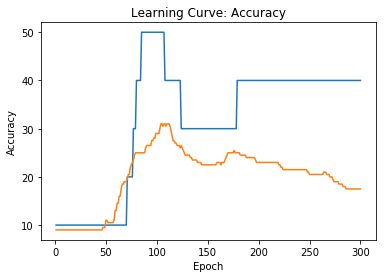

---------------------------------------------------
15 HIDDEN LAYERS - LEARNING RATE 1.0
Training time: 1.372990369796753


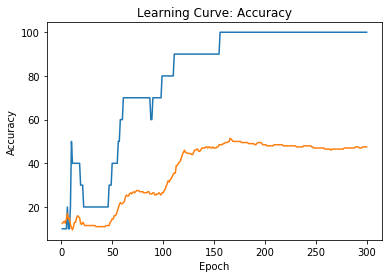

---------------------------------------------------
15 HIDDEN LAYERS - LEARNING RATE 10.0
Training time: 1.3756434917449951


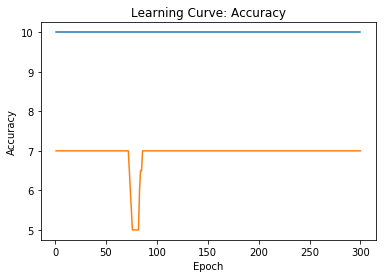

---------------------------------------------------
15 HIDDEN LAYERS - LEARNING RATE 2.0
Training time: 1.3742096424102783


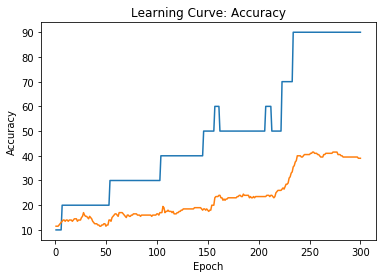

---------------------------------------------------
---------------------------------------------------
75 HIDDEN LAYERS - LEARNING RATE 0.1
Training time: 1.7128186225891113


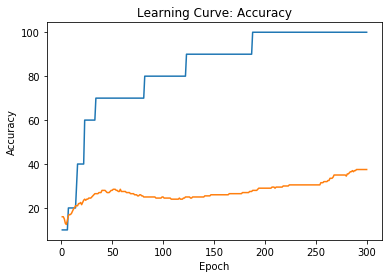

---------------------------------------------------
75 HIDDEN LAYERS - LEARNING RATE 1.0
Training time: 1.6999993324279785


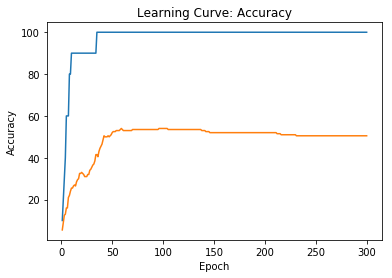

---------------------------------------------------
75 HIDDEN LAYERS - LEARNING RATE 10.0
Training time: 1.6957266330718994


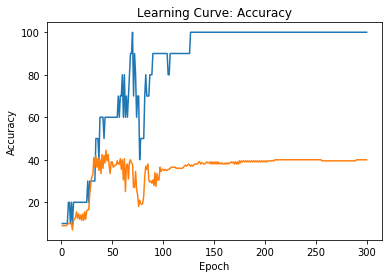

---------------------------------------------------
75 HIDDEN LAYERS - LEARNING RATE 2.0
Training time: 2.0965328216552734


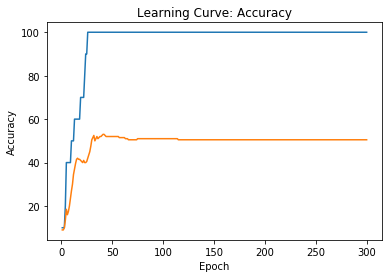

In [21]:
# Train NN and print accuracy on test data
# 30 hidden neurons
# Learning rate 0.1
# Learning rate 1.
# Learning rate 10.
mnist_model = NeuralNetwork(784, 30, 10, sigmoid, dsigmoid)
print("30 HIDDEN LAYERS - LEARNING RATE 0.1")
mnist_model.train(vsmall_training_data, small_validation_data, iterations=300, learning_rate=0.1, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("30 HIDDEN LAYERS - LEARNING RATE 1.0")
mnist_model.train(vsmall_training_data, small_validation_data, iterations=300, learning_rate=1, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("30 HIDDEN LAYERS - LEARNING RATE 10.0")
mnist_model.train(vsmall_training_data, small_validation_data, iterations=300, learning_rate=10, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("30 HIDDEN LAYERS - LEARNING RATE 2.0")
mnist_model.train(vsmall_training_data, small_validation_data, iterations=300, learning_rate=2, verbose=False)


# 15 hidden neurons
# Learning rate 0.1
# Learning rate 1.
# Learning rate 10.
mnist_model = NeuralNetwork(784, 15, 10, sigmoid, dsigmoid)
print("---------------------------------------------------")
print("---------------------------------------------------")
print("15 HIDDEN LAYERS - LEARNING RATE 0.1")
mnist_model.train(vsmall_training_data, small_validation_data, iterations=300, learning_rate=0.1, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("15 HIDDEN LAYERS - LEARNING RATE 1.0")
mnist_model.train(vsmall_training_data, small_validation_data, iterations=300, learning_rate=1, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("15 HIDDEN LAYERS - LEARNING RATE 10.0")
mnist_model.train(vsmall_training_data, small_validation_data, iterations=300, learning_rate=10, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("15 HIDDEN LAYERS - LEARNING RATE 2.0")
mnist_model.train(vsmall_training_data, small_validation_data, iterations=300, learning_rate=2, verbose=False)

# 75 hidden neurons
# Learning rate 0.1
# Learning rate 1.
# Learning rate 10.
mnist_model = NeuralNetwork(784, 75, 10, sigmoid, dsigmoid)
print("---------------------------------------------------")
print("---------------------------------------------------")
print("75 HIDDEN LAYERS - LEARNING RATE 0.1")
mnist_model.train(vsmall_training_data, small_validation_data, iterations=300, learning_rate=0.1, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("75 HIDDEN LAYERS - LEARNING RATE 1.0")
mnist_model.train(vsmall_training_data, small_validation_data, iterations=300, learning_rate=1, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("75 HIDDEN LAYERS - LEARNING RATE 10.0")
mnist_model.train(vsmall_training_data, small_validation_data, iterations=300, learning_rate=10, verbose=False)
mnist_model.weights_init()
print("---------------------------------------------------")
print("75 HIDDEN LAYERS - LEARNING RATE 2.0")
mnist_model.train(vsmall_training_data, small_validation_data, iterations=300, learning_rate=2, verbose=False)

<b>Question 2.1.5</b>: Explain the results you obtained at Questions 2.1.2, 2.1.3 and 2.1.4.

Answer: ...

<b>Question 2.1.6</b>: Among all the numbers of hidden neurons and learning rates you tried in previous questions, which ones would you expect to achieve best performances on the whole dataset? Justify your answer.

Answer: ...

<b>Question 2.1.7</b>: Train a model with the number of hidden neurons and the learning rate you chose in Question 2.1.6 and print its accuracy on the test set. You will use validation_data for validation. Training can be long on the whole dataset (~40 minutes): we suggest that you work on the optional part while waiting for the training to finish.

Training time: 550.2435071468353


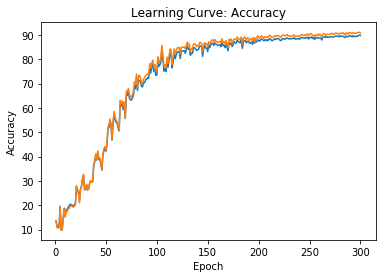

In [23]:
mnist_model = NeuralNetwork(784, 75, 10, sigmoid, dsigmoid)
mnist_model.train(training_data, validation_data, iterations=300, learning_rate=2.0, verbose=False)

<b>Part 2 (optional)</b>: Another loss function

In classification problems, we usually replace the sigmoids in the output layer by a "softmax" function and the MSE loss by a "cross-entropy" loss. More formally, let $u = (u_1, ..., u_n)$ be the vector representing the activation of the output layer of a Neural Network. The output of that neural network is $o = (o_1, ..., o_n) = \textrm{softmax}(u)$, and

<div align="center">$\textrm{softmax}(u) = (\frac{e^{u_1}}{\sum_{k=1}^n e^{u_k}}, ..., \frac{e^{u_n}}{\sum_{k=1}^n e^{u_k}})$.</div>

If $t = (t_1, ..., t_n)$ is a vector of non-negative targets such that $\sum_{k=1}^n t_k = 1$ (which is the case in classification problems, where one target is equal to 1 and all others are equal to 0), then the cross-entropy loss is defined as follows:

<div align="center">$L_{xe}(o, t) = - \sum_{k=1}^n t_k\log(o_k)$.</div>

<b>Question 2.2.1</b>: Let $L_{xe}$ be the cross-entropy loss function and $u_i$, $i \in \lbrace 1, ..., n \rbrace$, be the activations of the output neurons. Let us assume that the transfer function of the output neurons is the softmax function. Targets are $t_1, ..., t_n$. Derive a formula for $\frac{\partial L_{xe}}{\partial u_i}$ (details of your calculations are not required).

Answer: $\frac{\partial L_{xe}}{\partial u_i} = t_{i} \left (\frac{e^{u_{i}}}{ \sum_{k = 1}^{N} e^{u_{k}}} -  1\right ) = t_{i} (o_{i} - 1)$

<b>Question 2.2.2</b>: Implement a new feedforward() function and a new backpropagate() function adapted to the cross-entropy loss instead of the MSE loss.

In [8]:
class NeuralNetwork(NeuralNetwork):
    def feedforward_xe(self, inputs):
        self.o_input = np.array(inputs)
        
        # ADD COLUMN OF '1' TO INPUTS - IT'S THE BIAS
        if len(inputs[0]) == self.input_layer_size - 1:
            self.o_input = np.append(self.o_input, np.ones((len(inputs), 1)), axis=1)
        
        # FEEDFORWARD INPUT TO HIDDEN
        self.u_hidden = self.o_input.dot(self.W_input_to_hidden)
        self.o_hidden = self.transfer_f(self.u_hidden)
        
        # ADD COLUMN OF '1' TO O_HIDDEN - IT'S THE BIAS
        self.o_hidden = np.append(self.o_hidden, np.ones((len(self.o_hidden), 1)), axis=1)
        
        # FEEDFORWARD HIDDEN TO OUTPUT
        self.u_output = self.o_hidden.dot(self.W_hidden_to_output)
        self.o_output = softmax(self.u_output)

    def backpropagate_xe(self, targets, learning_rate=5.0):
        # COMPUTE dE/dU FOR OUTPUT LAYER
        dE_dU_output = self.o_output - targets
        
        # COMPUTE dE/dW FOR HIDDEN LAYER
        dE_dU_hidden = np.multiply(dE_dU_output.dot(self.W_hidden_to_output.T), self.o_hidden * (1 - self.o_hidden))
        dE_dU_hidden = np.delete(dE_dU_hidden, -1, axis=1)
    
        # COMPUTE dE/dW MATRIX NORMALIZING
        dE_dW_hidden = (2/len(targets)) * dE_dU_hidden.T.dot(self.o_input).T
        dE_dW_output = (2/len(targets)) * dE_dU_output.T.dot(self.o_hidden).T
        
        # UPDATE WEIGHTS
        self.W_hidden_to_output -= learning_rate * dE_dW_output
        self.W_input_to_hidden -= learning_rate * dE_dW_hidden

<b>Question 2.2.3</b>: Create a new Neural Network with the same architecture as in Question 2.1.1 and train it using the softmax cross-entropy loss.

Training time: 9.521728038787842


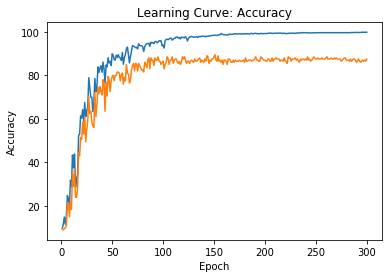

In [12]:
# Define your neural network
mnist_model_xe = NeuralNetwork(784, 30, 10, sigmoid, dsigmoid)

# Train NN and print accuracy on validation data
mnist_model_xe.train_xe(small_training_data, small_validation_data, iterations=300, learning_rate=1.8, verbose=False)

In [ ]:
# Print accuracy on test data

<b>Question 2.2.4</b>: Compare your results with the MSE loss and with the cross-entropy loss.

Answer: 

<div align="center"><b>THE END!</b>